# Michele Banfi 869294

In this exercise we needed to implement the grover algorithm in a non-trivial way to solve the boolean SAT problem.

In [189]:
# import libraries
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt
import numpy as np
from colorsys import hls_to_rgb
import re

In [190]:
# function to plot phases of the states
def plot_statevector_circles(statevector, figsize=(8, 8)):
    num_qubits = int(np.log2(len(statevector)))
    num_states = len(statevector)
    
    # Calculate grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_states)))  
 
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
 
    # Calculate radius for circles (adjust based on grid size)
    radius = 0.4 / grid_size 
 
    # Iterate through basis states and position circles on the grid
    for i, amp in enumerate(statevector):
        row = grid_size - (i // grid_size) - 1
        col = i % grid_size
 
        x = col * 2 * radius + radius  # Center x-coordinate of the circle
        y = row * 2 * radius + radius  # Center y-coordinate of the circle
 
        phase = np.angle(amp)
        hue = (phase + np.pi) / (2 * np.pi)  # Map phase to hue (0 to 1)
        color = hls_to_rgb(hue, 0.5, 1)
 
        circle = plt.Circle((x, y), np.abs(amp)*radius, color=color, alpha=0.5)  
        ax.add_artist(circle)
 
        ax.text(x, y, f"{bin(i)[2:].zfill(num_qubits)}", ha='center', va='center', fontsize=6)  
 
    # Set plot limits (adjust as needed)
    ax.set_xlim([0, grid_size * 2 * radius])
    ax.set_ylim([0, grid_size * 2 * radius])
    ax.set_title("Statevector Circle Notation")
    ax.set_xticks([]) # Remove x-axis ticks
    ax.set_yticks([]) # Remove y-axis ticks    
    plt.show()

As first attempt we want to implement this boolean expression in a circuit. Boolean expression: $(A \lor  (\neg B)) \land (B \lor (\neg A))$

In [191]:
# initialize the circuit
qc = QuantumCircuit(4)

# the qubits representing A and B are putted in superposition
qc.h([0, 1])
qc.barrier()

# then the first part of the expression is translated A AND (NOT B)
qc.x(1)
qc.x([0, 1]) # a second X is putted to the qubit in position 1 because in the formula we have NOT B
qc.mcx([0, 1], 2)
qc.x([0, 1])
qc.x(2)
qc.barrier()

# second part is implemented, B AND (NOT A)
qc.x(1)
qc.x(0)
qc.x([0, 1])
qc.mcx([0, 1], 3)
qc.x([0, 1])
qc.x(3)

# this brief section is for the central AND of the formula. The previous 2 blocks needs to be in AND together
qc.barrier()
qc.cz(2, 3)
qc.barrier()

# not we just to rewrite the previous part in reverse
qc.x(3)
qc.x([0, 1])
qc.mcx([0, 1], 3)
qc.x([0, 1])
qc.x(0)
qc.x(1)
qc.barrier()

qc.x(2)
qc.x([0, 1])
qc.mcx([0, 1], 2)
qc.x([0, 1])
qc.x(1)

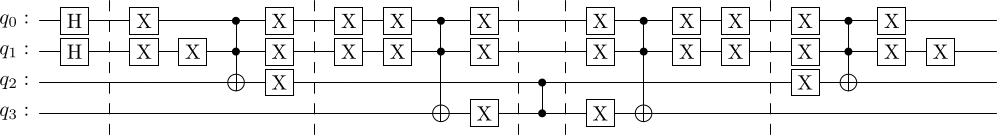

In [192]:
circuit_drawer(qc, output="latex")

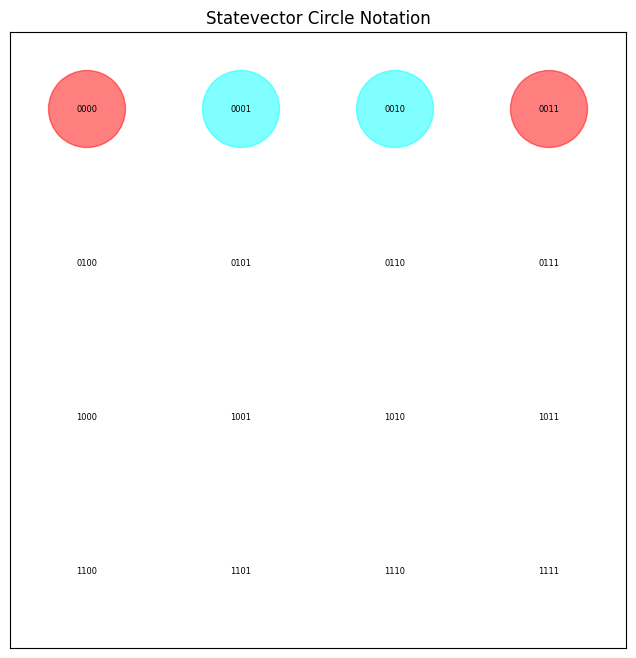

In [193]:
# Now we can plot the phase of the solution with the function written above

# create statevector
statevector = Statevector(qc)
# plot statevector
plot_statevector_circles(statevector)

Now we can implement a more difficult expression like the following, boolean expression: $(A \lor B) \land (\neg A \lor C) \land (\neg B \lor \neg C) \land (A \lor C) $. The reasoning is the same as before

In [194]:
qc =  QuantumCircuit(7)
qc.h([0, 1, 2])
qc.barrier()

qc.x([0, 1])
qc.mcx([0, 1], 3)
qc.x([0, 1, 3])
qc.barrier()

qc.x([0])
qc.x([0, 2])
qc.mcx([0, 2], 4)
qc.x([0, 2, 4])
qc.x([0])
qc.barrier()

qc.x([1, 2])
qc.x([1, 2])
qc.mcx([1, 2], 5)
qc.x([1, 2, 5])
qc.x([1, 2])
qc.barrier()

qc.x([0, 2])
qc.mcx([0, 2], 6)
qc.x([0, 2, 6])

qc.barrier()
qc.mcp(np.pi, [3, 4, 5], 6)
qc.barrier()

qc.x([0, 2, 6])
qc.mcx([0, 2], 6)
qc.x([0, 2])
qc.barrier()

qc.x([1, 2])
qc.x([1, 2, 5])
qc.mcx([1, 2], 5)
qc.x([1, 2])
qc.x([1, 2])
qc.barrier()

qc.x([0])
qc.x([0, 2, 4])
qc.mcx([0, 2], 4)
qc.x([0, 2])
qc.x([0])
qc.barrier()

qc.x([0, 1, 3])
qc.mcx([0, 1], 3)
qc.x([0, 1])

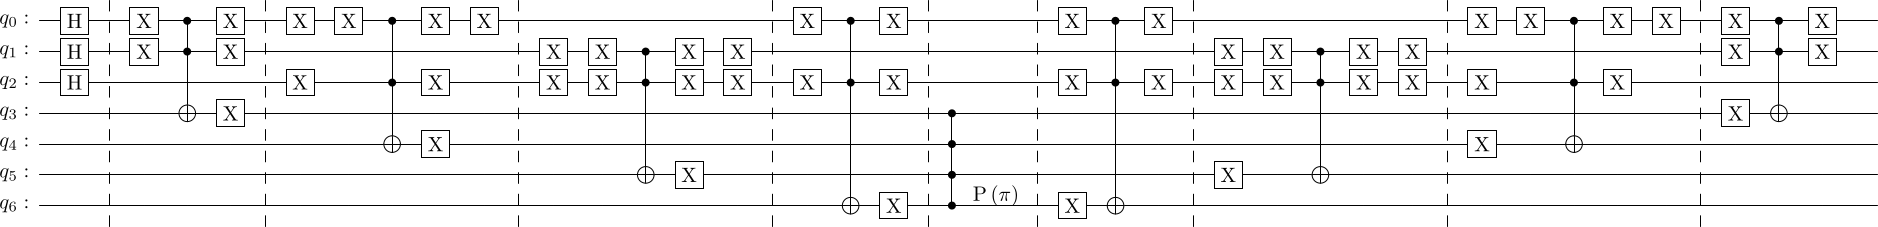

In [195]:
circuit_drawer(qc, output="latex")

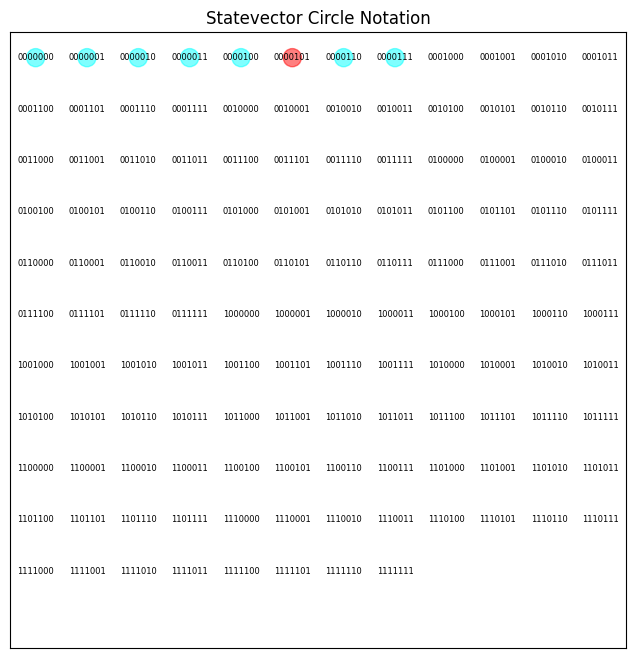

In [196]:
# create statevector
statevector = Statevector(qc)
# plot statevector
plot_statevector_circles(statevector)

Now we apply the reasoning we did before but with the grover algorithms

In [197]:
def oracle(qc):
    qc.x([0, 1])
    qc.mcx([0, 1], 3)
    qc.x([0, 1, 3])
    qc.barrier()

    qc.x([0])
    qc.x([0, 2])
    qc.mcx([0, 2], 4)
    qc.x([0, 2, 4])
    qc.x([0])
    qc.barrier()

    qc.x([1, 2])
    qc.x([1, 2])
    qc.mcx([1, 2], 5)
    qc.x([1, 2, 5])
    qc.x([1, 2])
    qc.barrier()

    qc.x([0, 2])
    qc.mcx([0, 2], 6)
    qc.x([0, 2, 6])
    
    qc.barrier()
    qc.mcp(np.pi, [3, 4, 5], 6)
    qc.barrier()
    
    qc.x([0, 2, 6])
    qc.mcx([0, 2], 6)
    qc.x([0, 2])
    qc.barrier()

    qc.x([1, 2])
    qc.x([1, 2, 5])
    qc.mcx([1, 2], 5)
    qc.x([1, 2])
    qc.x([1, 2])
    qc.barrier()

    qc.x([0])
    qc.x([0, 2, 4])
    qc.mcx([0, 2], 4)
    qc.x([0, 2])
    qc.x([0])

    qc.barrier()
    qc.x([0, 1, 3])
    qc.mcx([0, 1], 3)
    qc.x([0, 1])

In [198]:
def diffuser(qc, n):
    qc.h(range(n))
    qc.x(range(n))
    qc.mcp(np.pi, list(range(n-1)), n - 1)
    qc.x(range(n))
    qc.h(range(n))

In [199]:
n = 7
qc = QuantumCircuit(n)
qc.h([0, 1, 2])

for i in range(3):
    oracle(qc)
    diffuser(qc, 3)
    
qc.measure_all()
result = Sampler().run([qc], shots=100).result()[0]
co = result.data.meas.get_counts()

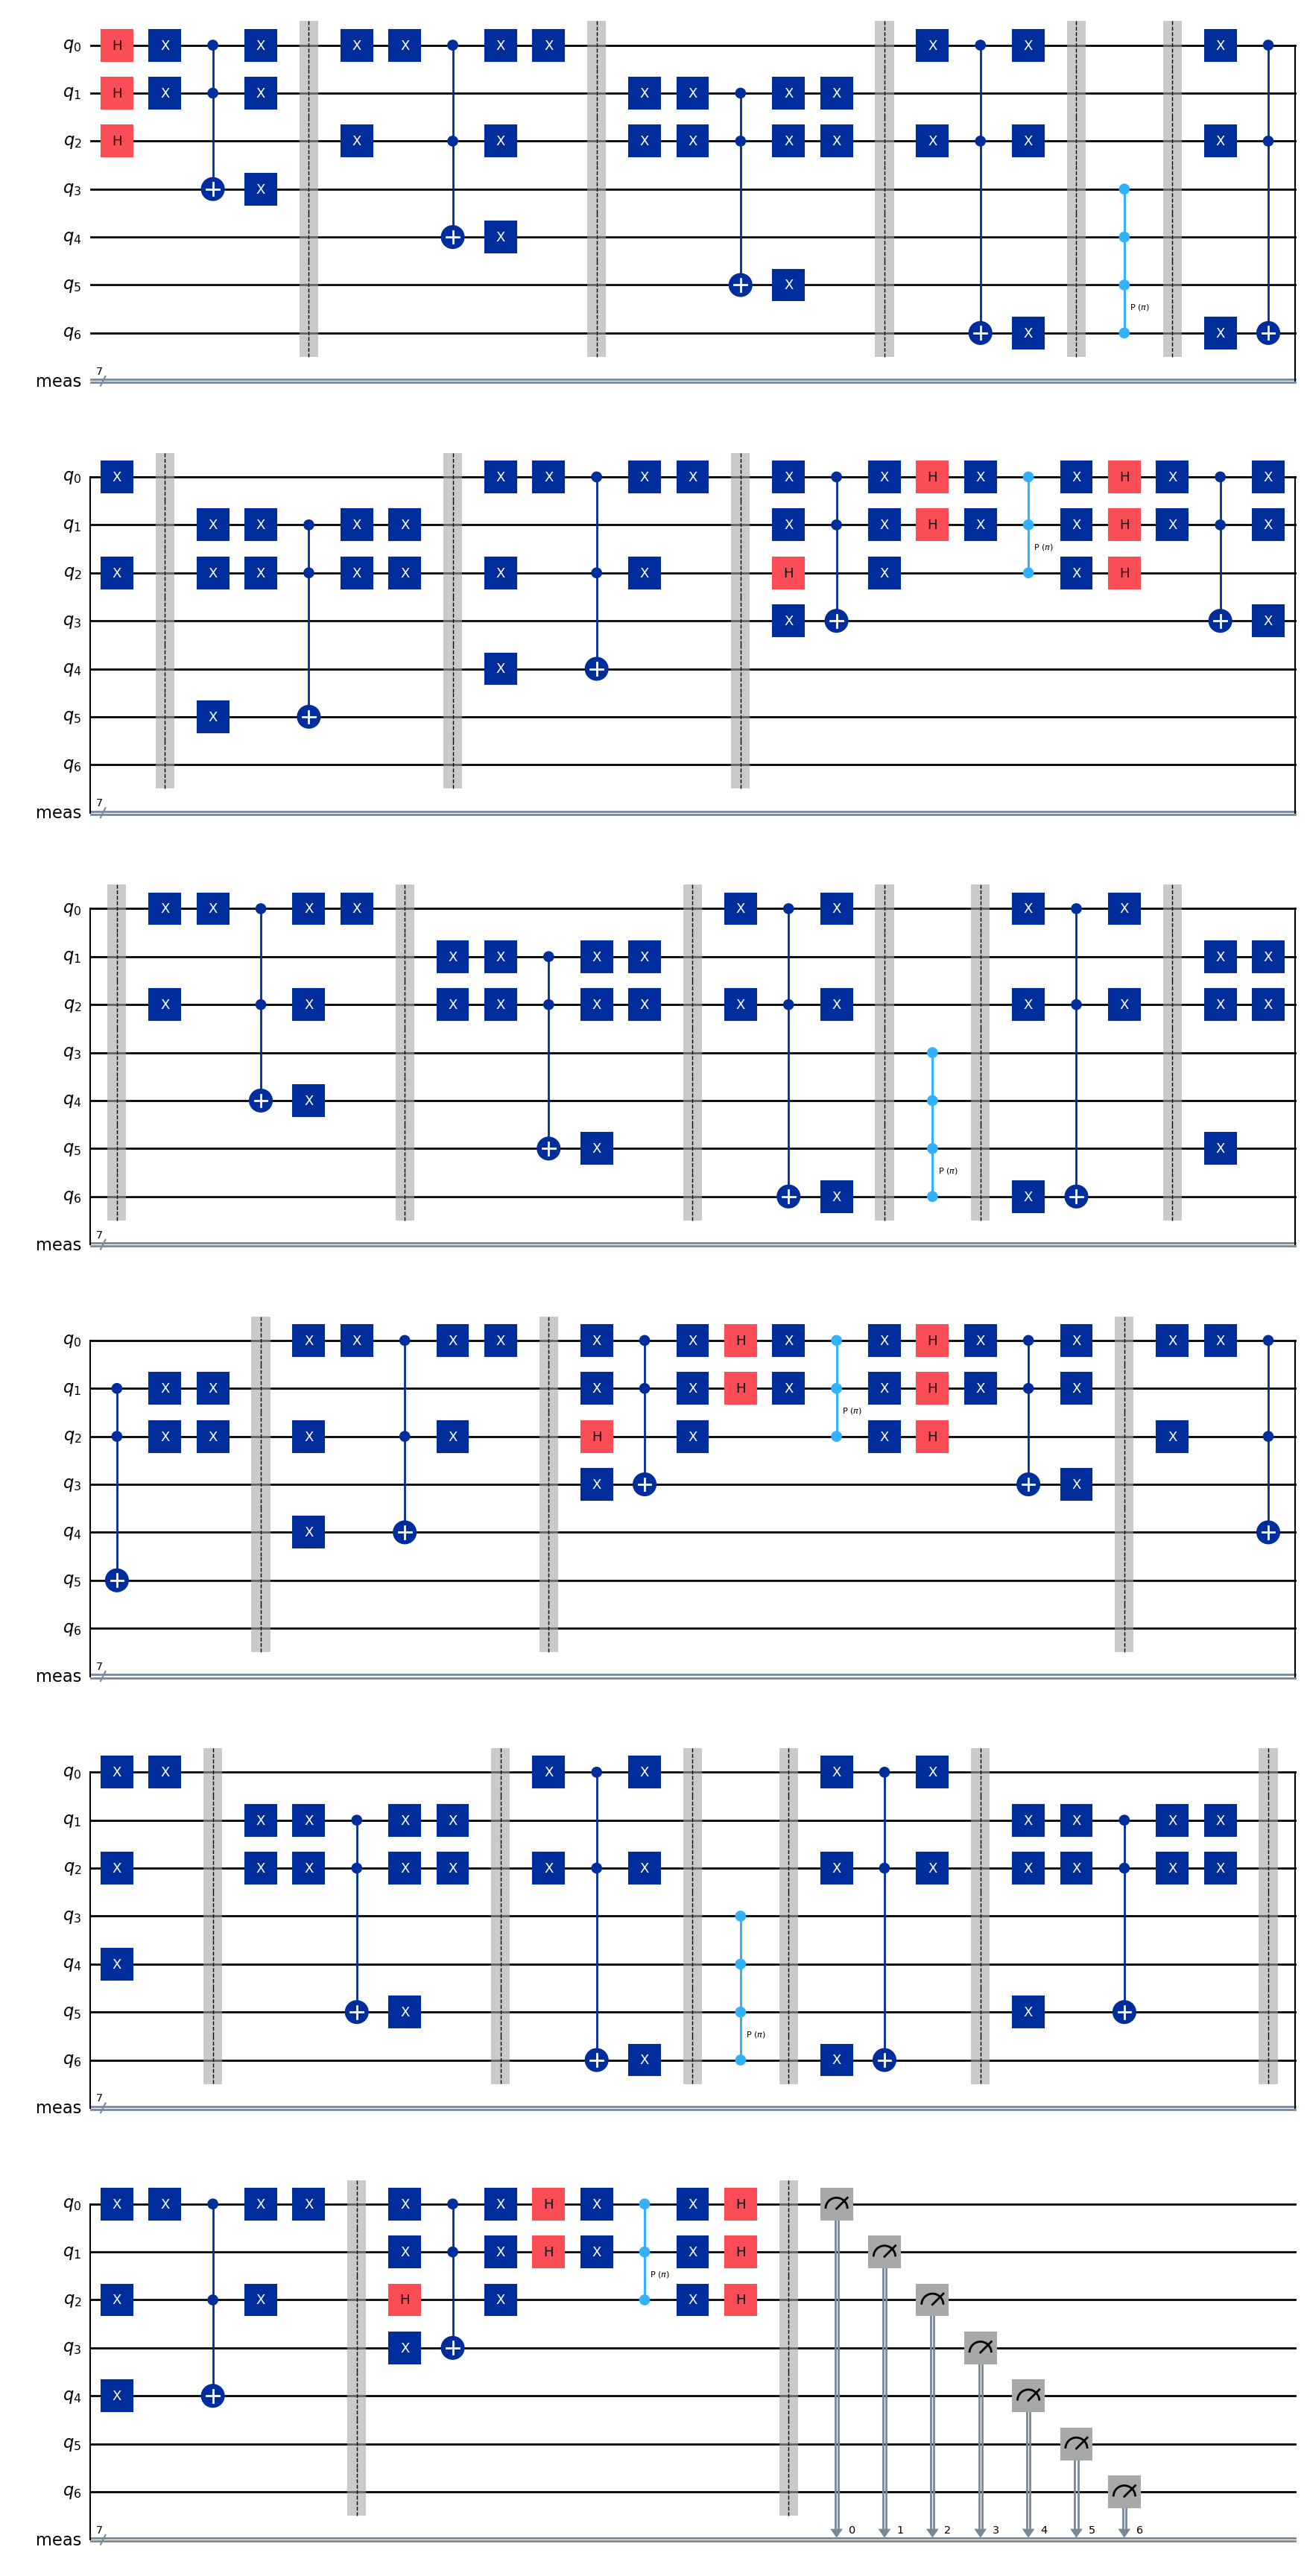

In [200]:
circuit_drawer(qc, output="mpl")

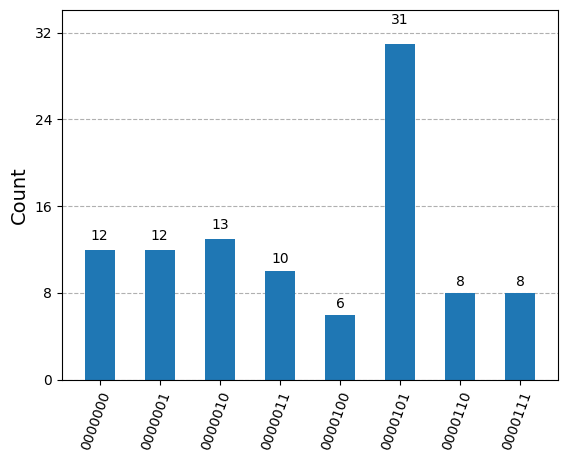

In [201]:
plot_histogram(co)

Now we can try to better generaliza the whole exercise. We take the same formula $(A \lor B) \land (\neg A \lor C) \land (\neg B \lor \neg C) \land (A \lor C) $

In [223]:
formula = "(A \lor B) \land (\neg A \lor C) \land (\neg B \lor \neg C) \land (A \lor C)"

In [224]:
# we need a way to parse the boolean expressions as LaTex strings
def tokenize(formula: str):
    # Replace LaTeX sequences with simple tokens and trim white spaces
    formula = repr(formula.replace(r'\land', '&').replace(r'\lor', '|')).replace(r'\neg', '~').replace(r" ", "")
    # Now, you can split by parentheses and operators. For a naive approach:
    tokens = re.findall(r'[A-Za-z]+|~[A-Za-z]+|[\(\)&|]', formula)
    return tokens

In [225]:
# Function to count unique uppercase letters
def count_unique_uppercase(tokens):
    # Extract all variable names (e.g., A, B, C) and store only their uppercase part
    variables = set(token for token in tokens if token.isalpha() and token.isupper())
    return len(variables), variables

In [226]:
tokens = tokenize(formula)
token_string = " ".join(tokens)
print(repr(token_string))

'( A | B ) & ( ~A | C ) & ( ~B | ~C ) & ( A | C )'


In [227]:
# Count uppercase variables
unique_count, unique_variables = count_unique_uppercase(tokens)
print(f"Number of unique uppercase letters: {unique_count}")
print(f"Unique uppercase letters: {unique_variables}")

# we can create a dictionary in order to look up the qubit corresponding to the letter:
var_dict = dict(zip(unique_variables, range(len(unique_variables))))
print(f"Look up table for the qubits: {var_dict}")

Number of unique uppercase letters: 3
Unique uppercase letters: {'A', 'B', 'C'}
Look up table for the qubits: {'A': 0, 'B': 1, 'C': 2}


In [228]:
from sympy.logic.boolalg import is_cnf, to_cnf
was_cnf = is_cnf(token_string)
print(was_cnf)

True


In [229]:
# if it is not a CNF convert it to a CNF with Sympy
if (not was_cnf):
    print("Not a CNF")
    token_string = to_cnf(token_string)

In [230]:
# now that we have a CNF we can create the circuit more easily
# we split by the &
or_clauses = token_string.split("&")

In [231]:
for clause in or_clauses:
    print(clause)

( A | B ) 
 ( ~A | C ) 
 ( ~B | ~C ) 
 ( A | C )


In [250]:
# we count how many qubits we need. We sum the number of unique_count with the number of clauses
n = unique_count + len(or_clauses)
n

7

In [251]:
def get_repr(qc, is_inv, clause, i):
    clause = clause.replace("(", "").replace(")", "").replace(" ", "")
    sub_clause = clause.split("|")
    first = False
    second = False
    if len(sub_clause[0]) == 2: first = True # means that the formula is notted
    if len(sub_clause[1]) == 2: second = True # same as above

    # look up positions
    clause = clause.replace("~", "")
    sub_clause = clause.split("|")
    pos1 = var_dict[sub_clause[0]]
    pos2 = var_dict[sub_clause[1]]
    # put notted synbols
    if first: qc.x(pos1)
    if second: qc.x(pos2)

    qc.x(pos1)
    qc.x(pos2)

    if is_inv:
        qc.x(i)

    qc.mcx([pos1, pos2], i)

    if not is_inv:
        qc.x(i)

    qc.x(pos1)
    qc.x(pos2)

    if first: qc.x(pos1)
    if second: qc.x(pos2)
    qc.barrier()

In [260]:
def oracle(qc):
    for i, clause in enumerate(or_clauses):
        get_repr(qc, False, clause, unique_count + i)

    qc.mcp(np.pi, list(range(unique_count,n-1)), n-1)
    qc.barrier()

    reversed_or_clauses = or_clauses[::-1]

    for clause in reversed_or_clauses:
        get_repr(qc, True, clause, unique_count + i)
        i -= 1

In [261]:
def diffuser(qc, n):
    qc.h(range(n))
    qc.x(range(n))
    qc.mcp(np.pi, list(range(n-1)), n - 1)
    qc.x(range(n))
    qc.h(range(n))
    qc.barrier()

In [262]:
def create_circuit(qc):
    oracle(qc)
    diffuser(qc, unique_count)

In [263]:
qc = QuantumCircuit(n)
create_circuit(qc)

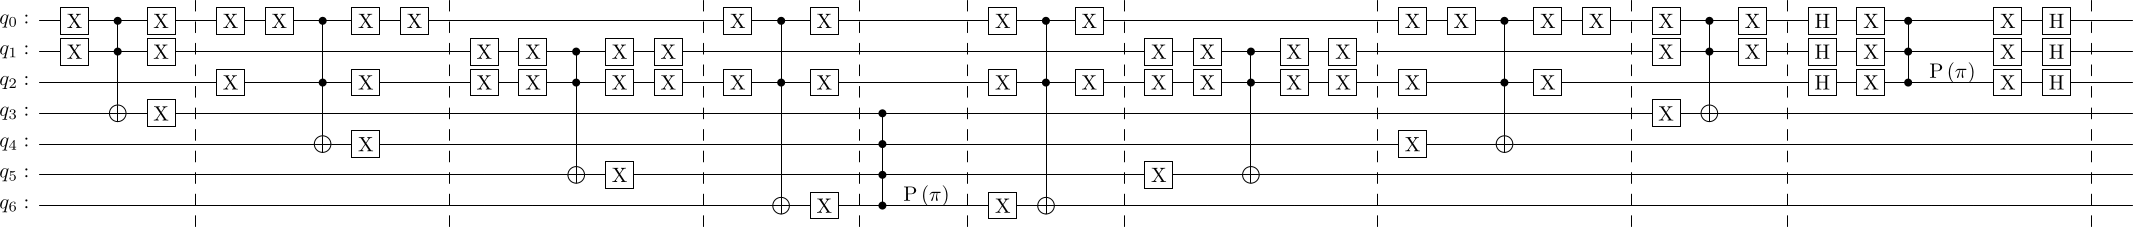

In [264]:
circuit_drawer(qc, output="latex")

In [265]:
# now we want to repeat the oracle and the diffuser sqrt(2^n) times
import math
reps = math.ceil( math.sqrt( 2**unique_count ))

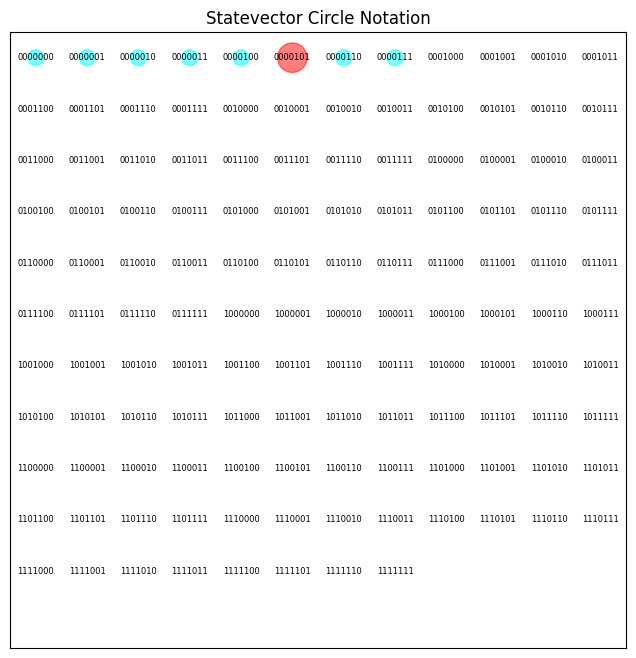

In [266]:
qc = QuantumCircuit(n)
qc.h(list(range(unique_count)))
for i in range(reps):
    create_circuit(qc)

# create statevector
statevector = Statevector(qc)
# plot statevector
plot_statevector_circles(statevector)

qc.measure_all()
result = Sampler().run([qc], shots=100).result()[0]

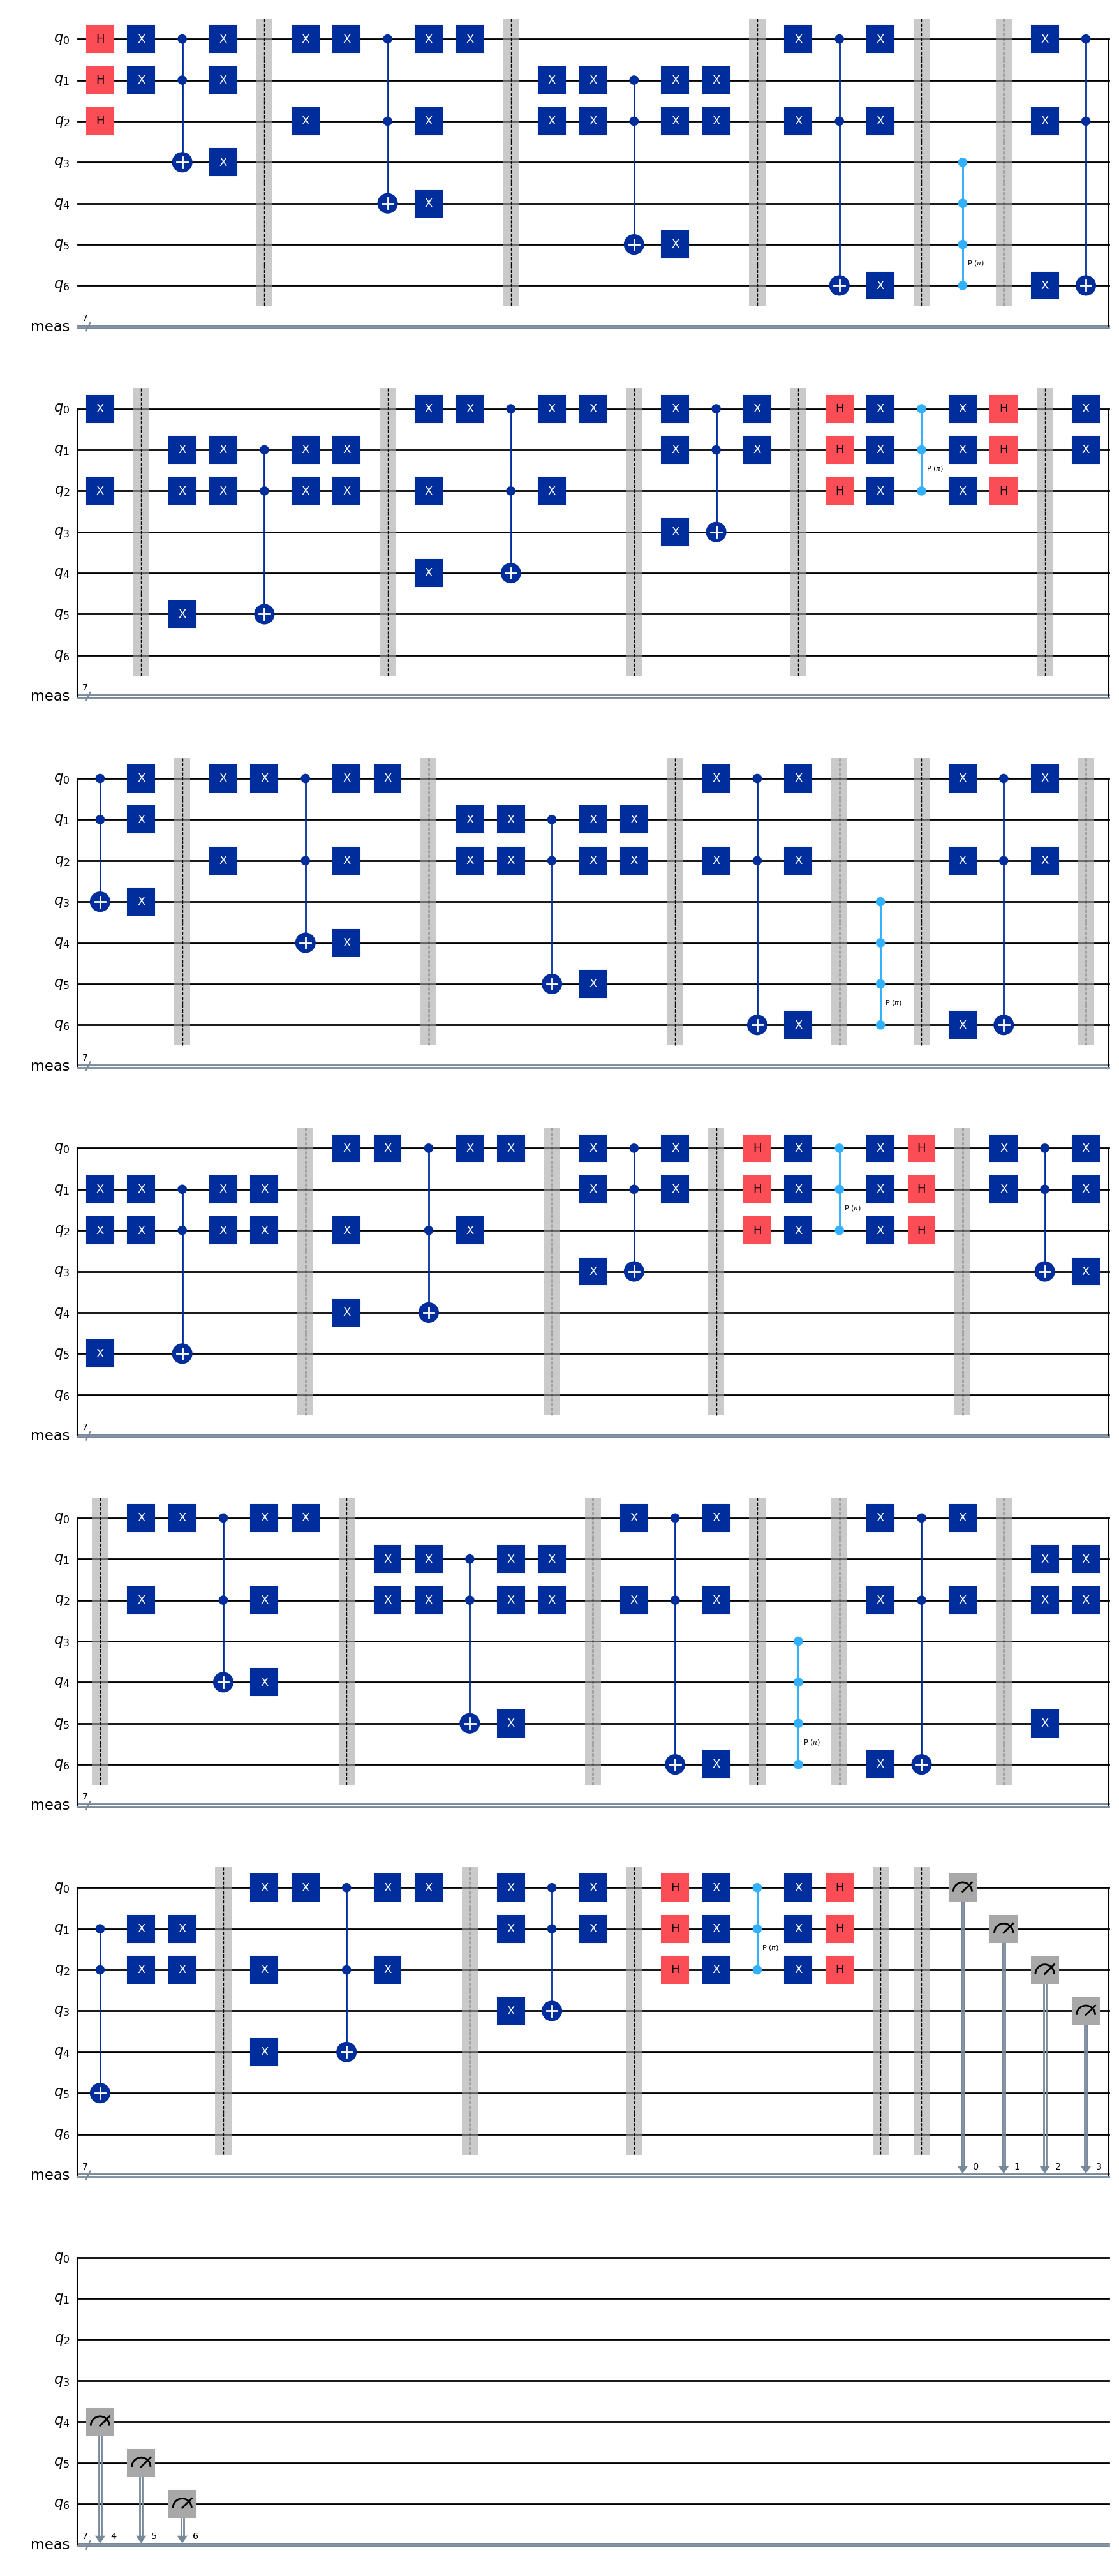

In [267]:
circuit_drawer(qc, output="mpl")

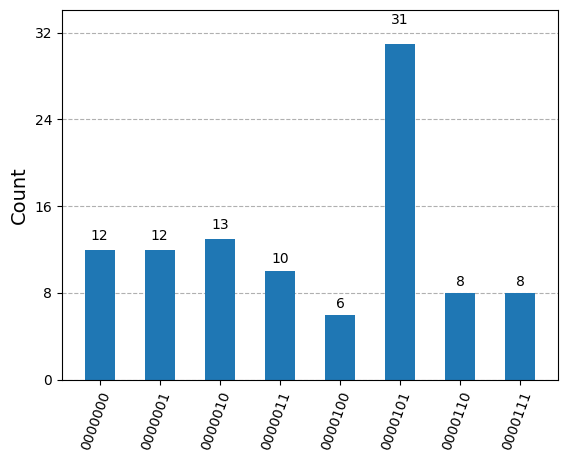

In [268]:
plot_histogram(co)